El informe tiene como objetivo identificar las características más importantes de los pacientes que desarrollan complicaciones infecciosas y requieren hospitalización después de someterse a una biopsia prostática. Se define como "caso" a aquel paciente que presenta fiebre, infección urinaria o sepsis en un máximo de 30 días después del procedimiento, necesitando atención médica ambulatoria u hospitalización para resolver la complicación. Se considera "control" al paciente que se somete a biopsia prostática y no experimenta complicaciones infecciosas en el período de 30 días posterior al procedimiento.

A partir de una serie de datos referentes a los pacientes y resultados de exámenes diagnósticos, tanto de pacientes hospitalizados como no hospitalizados, que posee nuestro departamento de datos, desarrollaremos un análisis para determinar las características que afectan a los pacientes y las razones por las cuales son hospitalizados.

A continuación, procederemos a importar las librerías necesarias para llevar a cabo nuestro análisis.

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

Conversión del documento de formato .xlsx a formato .csv.

In [6]:
# Lee el archivo Excel
df = pd.read_excel('BBDD_Hospitalizacion.xlsx')

# Guarda el DataFrame como un archivo CSV
df.to_csv('BBDD_Hospitalizacion.csv', index=False)  # se puede eliminar el índice del DataFrame si no es necesario en el archivo CSV

csv_file = 'BBDD_Hospitalizacion.csv'
print(f'Se ha creado el archivo CSV: {csv_file}')

Se ha creado el archivo CSV: BBDD_Hospitalizacion.csv


Procedemos a revisar los posibles valores faltantes que contiene nuestra BBDD_Hospitalizacion.csv.

In [7]:
# Leer el archivo CSV
df = pd.read_csv('BBDD_Hospitalizacion.csv')

# Contar los valores nulos en cada columna
valores_nulos_por_columna = df.isnull().sum()

print(valores_nulos_por_columna)

EDAD                                                                          0
DIABETES                                                                      0
HOSPITALIZACIÓN ULTIMO MES                                                    0
PSA                                                                           4
BIOPSIAS PREVIAS                                                              2
VOLUMEN PROSTATICO                                                            1
ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS                                       0
NUMERO DE MUESTRAS TOMADAS                                                    0
CUP                                                                           1
ENF. CRONICA PULMONAR OBSTRUCTIVA                                             2
BIOPSIA                                                                       0
NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA     0
FIEBRE                                  

### 1. Limpieza de la base de datos.

Se procederá a eliminar una serie de valores que no tienen relación con la enfermedad presentada y con posibles relaciones que conlleven a la internación del paciente. Además, se modificarán valores para poder mejorar la lectura de la base de datos.

In [8]:
# Lee el archivo CSV
df = pd.read_csv('BBDD_Hospitalizacion.csv')

# Reemplaza "NO" por 0 en la columna "NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA"
df.loc[df["NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA"] == "NO", "NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA"] = 0

# Reemplaza "SI, EPOC" por "SI" en la columna "ENF. CRONICA PULMONAR OBSTRUCTIVA"
df.loc[df["ENF. CRONICA PULMONAR OBSTRUCTIVA"] == "SI, EPOC", "ENF. CRONICA PULMONAR OBSTRUCTIVA"] = "SI"

# Reemplaza "SI, ASMA por "SI" en la columna "ENF. CRONICA PULMONAR OBSTRUCTIVA"
df.loc[df["ENF. CRONICA PULMONAR OBSTRUCTIVA"] == "SI, ASMA", "ENF. CRONICA PULMONAR OBSTRUCTIVA"] = "SI"

# Renombrar las columnas ITU por INFECCION DEL TRACTO URINARIO para poder identificar mejor
nuevos_nombres = {'ITU': 'INFECCION DEL TRACTO URINARIO '}
df = df.rename(columns=nuevos_nombres)

# Lista de columnas a eliminar debido a que no presentan características que representen una enfermedad, son resultados de las muestras tomadas
# e informacion del tiempo de hospitalizacion.
columnas_a_eliminar = [
    "HOSPITALIZACIÓN ULTIMO MES",
    "BIOPSIAS PREVIAS",
    "ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS",
    "NUMERO DE MUESTRAS TOMADAS",
    "CUP",
    "TIPO DE CULTIVO",
    "AGENTE AISLADO",
    "PATRON DE RESISTENCIA",
    "DIAS HOSPITALIZACION MQ",
    "DIAS HOSPITALIZACIÓN UPC"
]

# Elimina las columnas especificadas
df = df.drop(columnas_a_eliminar, axis=1)

# Reordenamos las columnas para un mayor entendimiento de los datos 
nuevas_columnas = ['EDAD', 'DIABETES', 'ENF. CRONICA PULMONAR OBSTRUCTIVA','INFECCION DEL TRACTO URINARIO ','FIEBRE','VOLUMEN PROSTATICO','PSA','BIOPSIA','NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA','HOSPITALIZACION']
df = df[nuevas_columnas]

# Llenar valores faltantes con la media en PSA
mean_psa = df['PSA'].mean()
df['PSA'] = df['PSA'].fillna(mean_psa)

# Eliminar filas con valores nulos, dado el tamaño de muestra y los pocos datos nulos encontrados, asuimos que la ausencia de estos no va a impactar en el 
# estudio.
df.dropna(inplace=True)

# Reemplazar valores atípicos encontrados en la edad 
df['EDAD'] = df['EDAD'].replace({151: 51, 143: 43})

# Guarda el DataFrame modificado como un archivo CSV
df.to_csv('BBDD_Hospitalizacion.csv', index=False)  

csv_file = 'BBDD_Hospitalizacion.csv'
print(f'Se ha modificado el archivo CSV : {csv_file}')

Se ha modificado el archivo CSV : BBDD_Hospitalizacion.csv


### 2. Métricas

In [9]:
# Leer el archivo CSV
df = pd.read_csv('BBDD_Hospitalizacion.csv')

Se procederá a realizar algunas métricas con la finalidad de poder entender el comportamiento de los datos y poder sacar algunas conclusiones en cómo impactan cada una de las enfermedades en el diagnóstico del paciente.

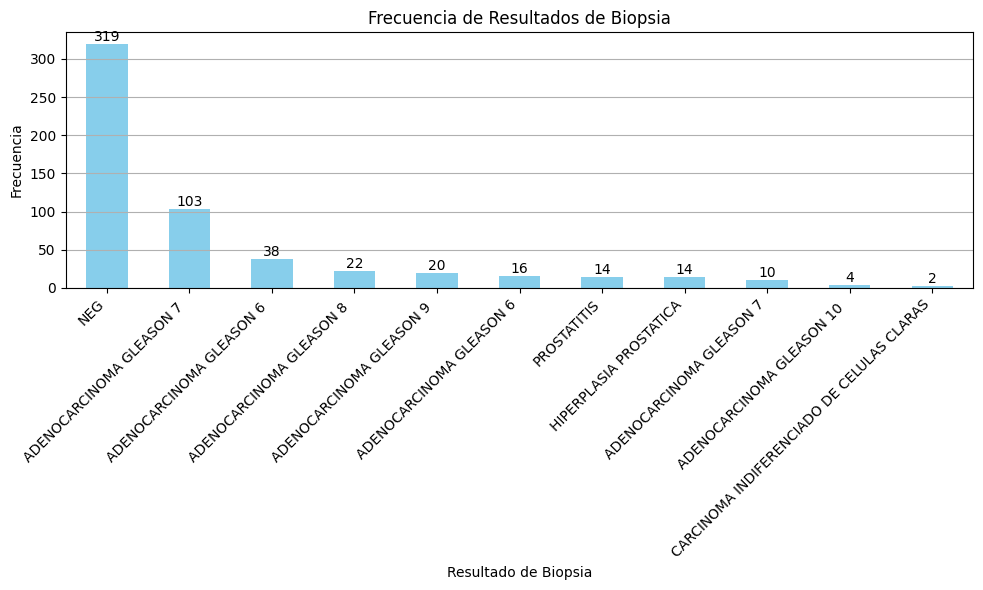

In [10]:
# Contar la frecuencia de cada categoría en la columna BIOPSIA
biopsia_counts = df['BIOPSIA'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
biopsia_counts.plot(kind='bar', color='skyblue')
plt.title('Frecuencia de Resultados de Biopsia')
plt.xlabel('Resultado de Biopsia')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje x y alinear a la derecha
plt.grid(axis='y')  # Agregar rejilla en el eje y
plt.tight_layout()

# Etiquetar cada barra con su frecuencia
for i, count in enumerate(biopsia_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Mostrar el gráfico
plt.show()

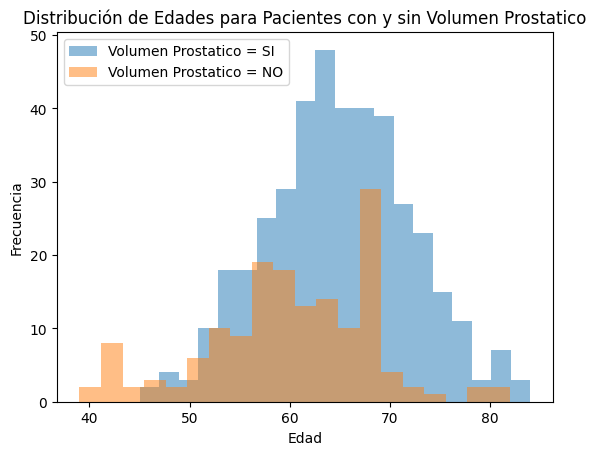

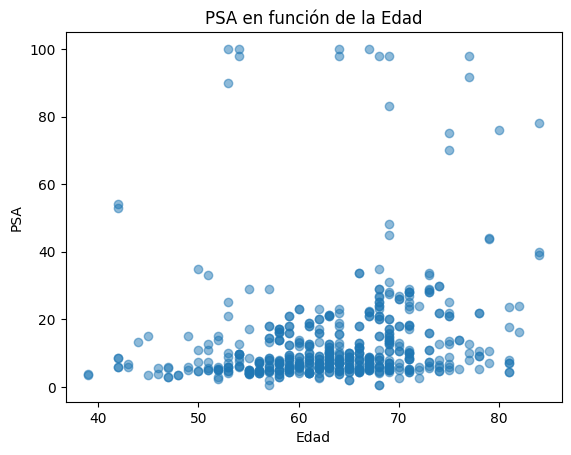

In [11]:
# creacion de un histograma donde muestra la relacion entre franjas de edades y si padecen diavetes
# Filtrar por aquellos que sufren de diabetes y aquellos que no
VOLUMEN_PROSTATICO_si = df[df['VOLUMEN PROSTATICO'] == 'SI']
VOLUMEN_PROSTATICO_no = df[df['VOLUMEN PROSTATICO'] == 'NO']

# Crear histogramas superpuestos
plt.hist(VOLUMEN_PROSTATICO_si['EDAD'], bins=20, alpha=0.5, label='Volumen Prostatico = SI')
plt.hist(VOLUMEN_PROSTATICO_no['EDAD'], bins=20, alpha=0.5, label='Volumen Prostatico = NO')

# Añadir etiquetas y leyenda
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.title('Distribución de Edades para Pacientes con y sin Volumen Prostatico')
plt.legend()

# Mostrar el gráfico
plt.show()


# creacion de un diagrama de dispercion que muestra la relacion entre el volumen de PSA en sangre y la edad 
plt.scatter(df['EDAD'], df['PSA'], alpha=0.5)

# Etiquetas y título
plt.xlabel('Edad')
plt.ylabel('PSA')
plt.title('PSA en función de la Edad')

# Mostrar el gráfico
plt.show()

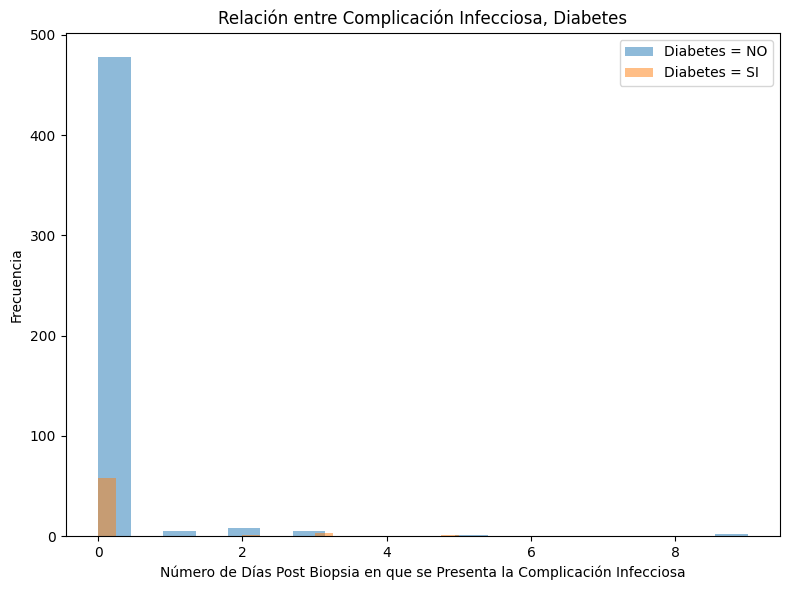

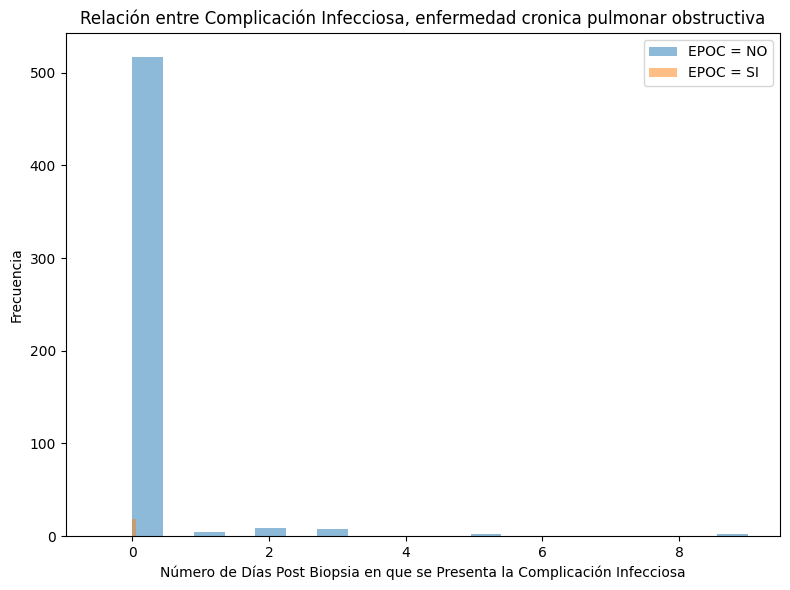

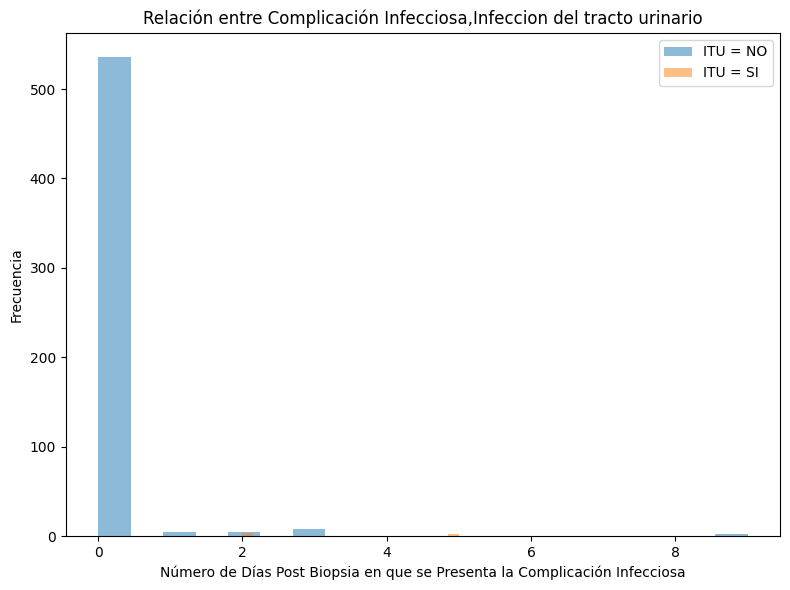

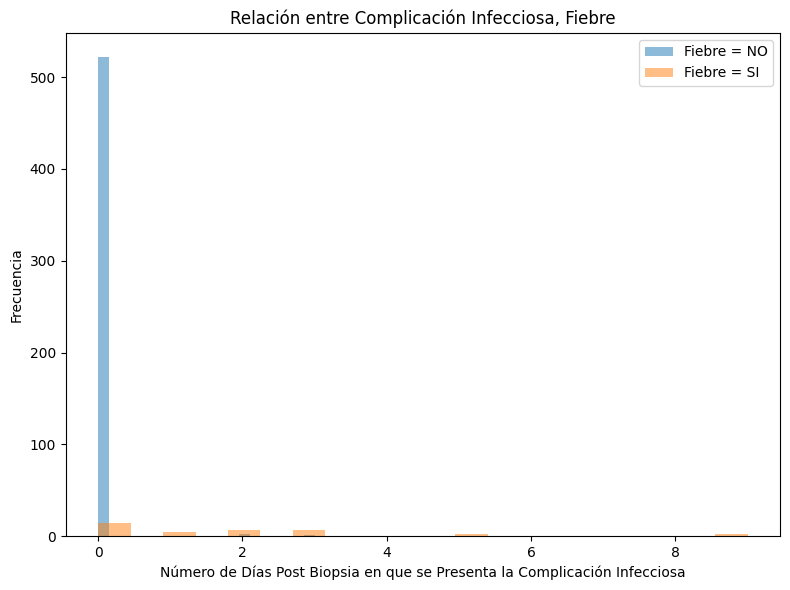

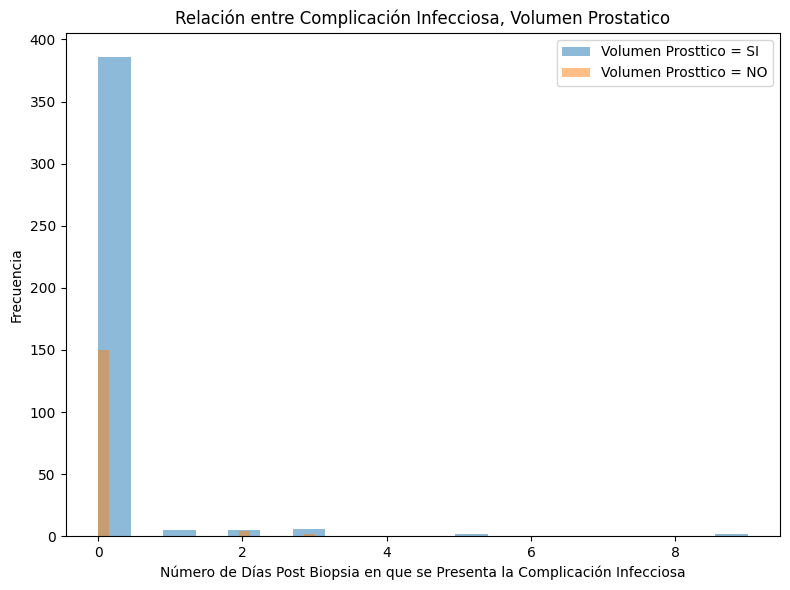

In [12]:
# Filtrar por aquellos que tienen diabetes y los que no tienen
diabetes_si = df[df['DIABETES'] == 'SI']
diabetes_no = df[df['DIABETES'] == 'NO']

# Definir el tamaño del gráfico
plt.figure(figsize=(8, 6))  # Ancho x Alto

# Crear gráfico de dispersión
plt.hist(diabetes_no['NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA'], bins=20, alpha=0.5, label='Diabetes = NO')
plt.hist(diabetes_si['NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA'], bins=20, alpha=0.5, label='Diabetes = SI')

# Etiquetas y título
plt.xlabel('Número de Días Post Biopsia en que se Presenta la Complicación Infecciosa')
plt.ylabel('Frecuencia')
plt.title('Relación entre Complicación Infecciosa, Diabetes')
plt.legend()

# Ajustar el diseño del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Filtrar por aquellos que tienen ENF. CRONICA PULMONAR OBSTRUCTIVA y los que no tienen
epoc_si = df[df['ENF. CRONICA PULMONAR OBSTRUCTIVA'] == 'SI']
epoc_no = df[df['ENF. CRONICA PULMONAR OBSTRUCTIVA'] == 'NO']

# Definir el tamaño del gráfico
plt.figure(figsize=(8, 6))  # Ancho x Alto

# Crear gráfico de dispersión
plt.hist(epoc_no['NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA'], bins=20, alpha=0.5, label='EPOC = NO')
plt.hist(epoc_si['NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA'], bins=20, alpha=0.5, label='EPOC = SI')

# Etiquetas y título
plt.xlabel('Número de Días Post Biopsia en que se Presenta la Complicación Infecciosa')
plt.ylabel('Frecuencia')
plt.title('Relación entre Complicación Infecciosa, enfermedad cronica pulmonar obstructiva')
plt.legend()

# Ajustar el diseño del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Filtrar por aquellos que tienen INFECCION DEL TRACTO URINARIO y los que no tienen
ITU_si = df[df['INFECCION DEL TRACTO URINARIO '] == 'SI']
ITU_no = df[df['INFECCION DEL TRACTO URINARIO '] == 'NO']

# Definir el tamaño del gráfico
plt.figure(figsize=(8, 6))  # Ancho x Alto

# Crear gráfico de dispersión
plt.hist(ITU_no['NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA'], bins=20, alpha=0.5, label='ITU = NO')
plt.hist(ITU_si['NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA'], bins=20, alpha=0.5, label='ITU = SI')

# Etiquetas y título
plt.xlabel('Número de Días Post Biopsia en que se Presenta la Complicación Infecciosa')
plt.ylabel('Frecuencia')
plt.title('Relación entre Complicación Infecciosa,Infeccion del tracto urinario')
plt.legend()

# Ajustar el diseño del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Filtrar por aquellos que presentaron fiebre  y los que no tienen
FIEBRE_si = df[df['FIEBRE'] == 'SI']
FIEBRE_no = df[df['FIEBRE'] == 'NO']

# Definir el tamaño del gráfico
plt.figure(figsize=(8, 6))  # Ancho x Alto

# Crear gráfico de dispersión
plt.hist(FIEBRE_no['NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA'], bins=20, alpha=0.5, label='Fiebre = NO')
plt.hist(FIEBRE_si['NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA'], bins=20, alpha=0.5, label='Fiebre = SI')

# Etiquetas y título
plt.xlabel('Número de Días Post Biopsia en que se Presenta la Complicación Infecciosa')
plt.ylabel('Frecuencia')
plt.title('Relación entre Complicación Infecciosa, Fiebre')
plt.legend()

# Ajustar el diseño del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Filtrar por aquellos que presentaron fiebre  y los que no tienen
VOLUMEN_PROSTATICO_si = df[df['VOLUMEN PROSTATICO'] == 'SI']
VOLUMEN_PROSTATICO_no = df[df['VOLUMEN PROSTATICO'] == 'NO']

# Definir el tamaño del gráfico
plt.figure(figsize=(8, 6))  # Ancho x Alto

# Crear gráfico de dispersión
plt.hist(VOLUMEN_PROSTATICO_si['NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA'], bins=20, alpha=0.5, label='Volumen Prosttico = SI')
plt.hist(VOLUMEN_PROSTATICO_no['NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA'], bins=20, alpha=0.5, label='Volumen Prosttico = NO')


# Etiquetas y título
plt.xlabel('Número de Días Post Biopsia en que se Presenta la Complicación Infecciosa')
plt.ylabel('Frecuencia')
plt.title('Relación entre Complicación Infecciosa, Volumen Prostatico')
plt.legend()

# Ajustar el diseño del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

De estos últimos gráficos podemos observar que existe una fuerte relación entre los pacientes que tienen un alto volumen prostático y aquellos pacientes que son hospitalizados luego de la biopsia.

### 3. Modelamiento

In [13]:
# Leer el archivo CSV
df = pd.read_csv('BBDD_Hospitalizacion.csv')

Se procede a separar las variables X e y (variable objetivo).

In [14]:
# Preprocesamiento de datos
X = df.drop(columns=['HOSPITALIZACION'])  # Características
y = df['HOSPITALIZACION']  # Variable objetivo

Convertir variables categóricas en variables dummy

In [15]:
# Convertir variables categóricas en variables dummy
X = pd.get_dummies(X)

Se procede a separar el conjunto de datos en X_train, X_test, y_train y y_test.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Se inicia, entrena y predice sobre un árbol de decisión asignando una profundidad máxima arbitraria.

In [17]:
# Instanciar y entrenar el modelo de árbol de decisión
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

Se procede a construir una matriz de confusión para evaluar el desempeño del modelo de clasificación.

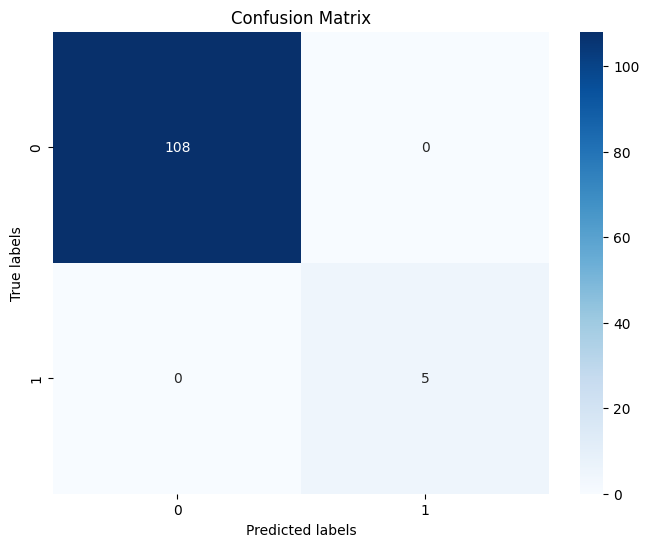

In [18]:
# Predicciones del modelo en el conjunto de prueba
y_pred = tree_model.predict(X_test)

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Crear el mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Se seleccionan tres métricas de evaluación para este modelo de clasificación para poder entender el comportamiento de este.

In [19]:
# Calcular el classification_report
report=classification_report(y_test,y_pred)

# Imprimir el reporte
print(report)

              precision    recall  f1-score   support

          NO       1.00      1.00      1.00       108
          SI       1.00      1.00      1.00         5

    accuracy                           1.00       113
   macro avg       1.00      1.00      1.00       113
weighted avg       1.00      1.00      1.00       113



Se realiza un diagrama de la importancia de cada una de las variables con respecto a la clasificación de la variable objetivo, con la finalidad de entender qué características son más relevantes para el modelo de clasificación.

C:\Users\varel\AppData\Local\Temp\ipykernel_12592\1368703433.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


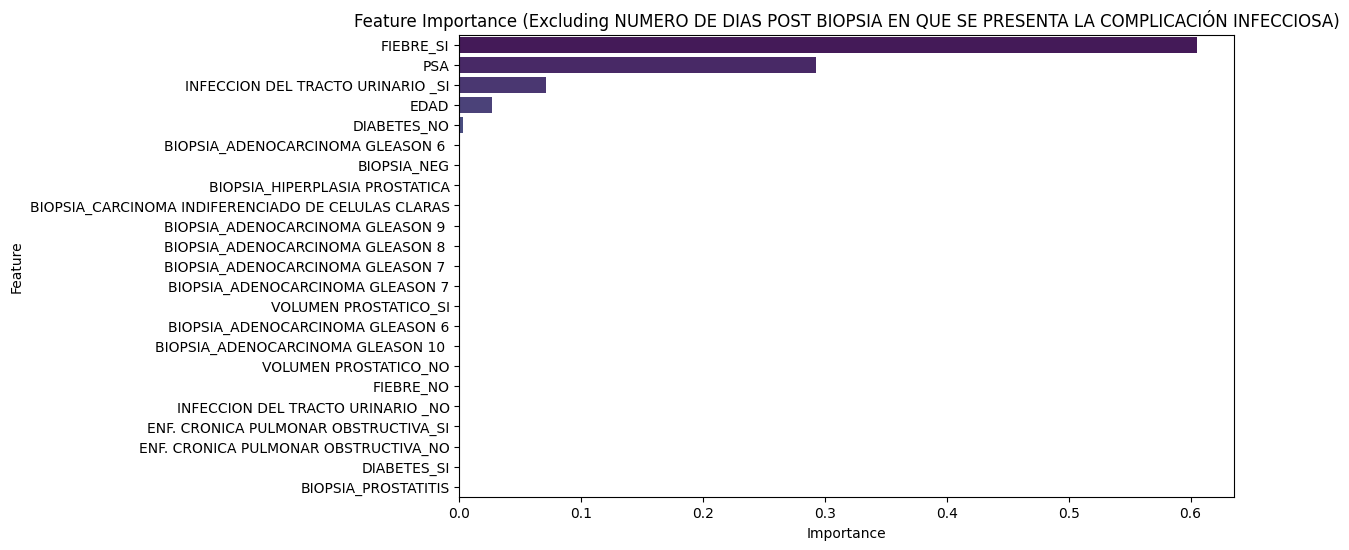

In [21]:
# Especifica el nombre de la columna a excluir
column_to_exclude = 'NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA'

# Elimina la columna del DataFrame X antes de calcular la importancia de las características
X_without_column = X.drop(columns=[column_to_exclude])

# Entrena nuevamente el modelo de árbol de decisión con X_without_column
tree_model.fit(X_without_column, y)

# Obtén la importancia de las características del modelo de árbol de decisión
feature_importance = tree_model.feature_importances_

# Crea un DataFrame con las características y sus importancias
feature_importance_df = pd.DataFrame({'Feature': X_without_column.columns, 'Importance': feature_importance})

# Ordena las características por importancia en orden descendente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Crea el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Excluding ' + column_to_exclude + ')')
plt.show()

A la luz de las observaciones y datos obtenidos, podemos concluir que las características más importantes de los pacientes con cierto tipo de enfermedad que terminan hospitalizados son aquellos que presentan:

- Fiebre
- Alto índice de PSA (Antígeno Prostático Específico)
- Infección del tracto urinario
- Edad

Y en menor medida:

- Diabetes

